# Pull census data for the neighborhoods in Seattle
## Want to get median income

In [1]:
import pandas as pd
import censusdata
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
sample = censusdata.search('acs5', 2018,'concept', 'household income')

In [34]:
print(sample[0])

('B19001A_001E', 'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) (WHITE ALONE HOUSEHOLDER)', 'Estimate!!Total')


In [9]:
states = censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2018)

In [16]:
print(states['Washington'])

Summary level: 040, state:53


In [17]:
counties = censusdata.geographies(censusdata.censusgeo([('state', '53'), ('county', '*')]), 'acs5', 2018)

In [20]:
print(counties['King County, Washington'])

Summary level: 050, state:53> county:033


## Collect income data for King County

In [36]:
data = censusdata.download('acs5', 2018,
           censusdata.censusgeo([('state', '53'),
                                 ('county', '033'),
                                 ('tract', '*')]),
                                  ['B19013_001E'])

In [41]:
data.head()

,B19013_001E,tract
"Census Tract 323.09, King County, Washington: Summary level: 140, state:53> county:033> tract:032309",118770,"Census Tract 323.09, King County, Washington: ..."
"Census Tract 317.04, King County, Washington: Summary level: 140, state:53> county:033> tract:031704",102639,"Census Tract 317.04, King County, Washington: ..."
"Census Tract 323.13, King County, Washington: Summary level: 140, state:53> county:033> tract:032313",119250,"Census Tract 323.13, King County, Washington: ..."
"Census Tract 323.19, King County, Washington: Summary level: 140, state:53> county:033> tract:032319",72569,"Census Tract 323.19, King County, Washington: ..."
"Census Tract 323.21, King County, Washington: Summary level: 140, state:53> county:033> tract:032321",210341,"Census Tract 323.21, King County, Washington: ..."


In [40]:
data['tract']=data.index

In [57]:
df = data

In [59]:
#convert object type to string
df['tract']= df['tract'].astype(str)

In [60]:
#Split out uneeded info
df[['tract']] = df['tract'].str.split(',').str[0] #Get the first value
df[['tract']] = df['tract'].str.split(' ').str[2] #Remove the words so only tract number remains

In [78]:
#convert object type to float
df['tract']= df['tract'].astype(float)

In [12]:
#There may be missing values listed as -666666. Delete those.
df = df[df['B19013_001E'] >= 0]
df.head()

,household_income,tract
0,118770,323.09
1,102639,317.04
2,119250,323.13
3,72569,323.19
4,210341,323.21


In [ ]:
df.to_csv('seattle-census-tract-acs5-2018.csv', mode = 'w', index=False)

In [3]:
#Open the full tract file if needed
df = pd.read_csv('seattle-census-tract-acs5-2018.csv',encoding='utf-8')

### Regression for income and LFLs per population for all of Seattle
This merges population and lfl number data for tracts with the income data

In [ ]:
from sklearn.linear_model import LinearRegression

In [16]:
#Open the file if needed
df = pd.read_csv('seattle-census-tract-acs5-2018.csv',encoding='utf-8')
lflvtract = pd.read_csv('census-tracts-lfl-counts.csv',encoding='utf-8')
pop = pd.read_csv('pop-by-tract.csv',encoding='utf-8')

In [20]:
#Merge with the population dataframe
dfregr = pd.merge(df, pop, on='tract', how='inner')
dfregr.head()

,household_income,tract,pop
0,118770,323.09,5212
1,102639,317.04,5539
2,119250,323.13,5576
3,72569,323.19,4703
4,210341,323.21,4959


In [21]:
#Merge with the lfl number dataset
dfregr = pd.merge(dfregr, lflvtract, on='tract', how='inner')
dfregr.head()

,household_income,tract,pop,sqkm,numlfls,lflsperarea
0,63536,109.00,1287,4813.254792,1,0.000208
1,112224,67.00,6544,1233.161632,2,0.001622
2,87188,101.00,6553,2494.925767,6,0.002405
3,84491,111.02,4419,1297.859167,1,0.000771
4,32262,4.01,5551,1363.674912,0,0.000000


In [22]:
dfregr['lflperpop'] = dfregr['numlfls']/dfregr['pop']

In [24]:
#In case there are any negative values
dfregr = dfregr[dfregr['household_income'] >= 0]

[(0, 0.005)]

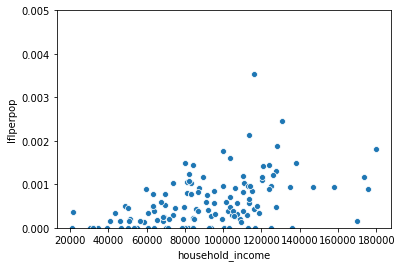

In [25]:
ax = sns.scatterplot(x="household_income", y="lflperpop", data=dfregr)
ax.set(ylim=(0, 0.005))

In [26]:
x = dfregr[['household_income']]
y = dfregr[['lflperpop']]

In [27]:
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

coefficient of determination: 0.22337423658402425
intercept: [-0.00020775]
slope: [[8.62944866e-09]]


## Collect diversity numbers

In [29]:
sample = censusdata.search('acs5', 2018,'concept', 'families')
print(sample[0])

('B05009_001E', 'AGE AND NATIVITY OF OWN CHILDREN UNDER 18 YEARS IN FAMILIES AND SUBFAMILIES BY NUMBER AND NATIVITY OF PARENTS', 'Estimate!!Total')


In [58]:
# This gets data for total, white, african american, american indian, asian, hawaiian, other, and three combineation categories.
#https://api.census.gov/data/2016/acs/acs5/groups/B02001.html
divdata = censusdata.download('acs5', 2016,
           censusdata.censusgeo([('state', '53'),
                                 ('county', '033'),
                                 ('tract', '*')]),
                                  ['B02001_001E',
                                   'B02001_002E', 
                                   'B02001_003E',
                                   'B02001_004E',
                                   'B02001_005E',
                                   'B02001_006E',
                                   'B02001_007E',
                                  'B02001_008E',
                                  'B02001_009E',
                                  'B02001_010E'])

In [55]:
divdata.head()

,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_007E,B02001_008E,B02001_009E,B02001_010E
"Census Tract 1, King County, Washington: Summary level: 140, state:53> county:033> tract:000100",4437,1010,60,767,122,346,519,64,455
"Census Tract 2, King County, Washington: Summary level: 140, state:53> county:033> tract:000200",4831,681,84,1396,0,281,629,28,601
"Census Tract 3, King County, Washington: Summary level: 140, state:53> county:033> tract:000300",2208,112,31,194,112,0,173,24,149
"Census Tract 4.01, King County, Washington: Summary level: 140, state:53> county:033> tract:000401",3772,997,38,1040,0,0,411,0,411
"Census Tract 4.02, King County, Washington: Summary level: 140, state:53> county:033> tract:000402",4168,284,24,324,42,57,266,0,266


In [59]:
#Create a new dataframe incase something gets messed up
df = divdata

#Rename columns and parse index
df['tract']=df.index
#convert object type to string
df['tract']= df['tract'].astype(str)
#Split out uneeded info
df[['tract']] = df['tract'].str.split(',').str[0] #Get the first value
df[['tract']] = df['tract'].str.split(' ').str[2] #Remove the words so only tract number remains
#convert object type to float
df['tract']= df['tract'].astype(float)
df.rename(columns={'B02001_001E':'tot','B02001_002E':'wh',
                        'B02001_003E':'afam',
                        'B02001_004E':'amin',
                        'B02001_005E':'as',
                        'B02001_006E':'hw',
                        'B02001_007E':'ot',
                       'B02001_008E':'combo1',
                        'B02001_009E':'combo2',
                        'B02001_010E':'combo3'}, inplace=True)

#Drop any rows that have a zero for tot column
df.drop(df[df['tot'] == 0].index, inplace = True) 

df.head()

,tot,wh,afam,amin,as,hw,ot,combo1,combo2,combo3,tract
"Census Tract 1, King County, Washington: Summary level: 140, state:53> county:033> tract:000100",7261,4437,1010,60,767,122,346,519,64,455,1.00
"Census Tract 2, King County, Washington: Summary level: 140, state:53> county:033> tract:000200",7902,4831,681,84,1396,0,281,629,28,601,2.00
"Census Tract 3, King County, Washington: Summary level: 140, state:53> county:033> tract:000300",2830,2208,112,31,194,112,0,173,24,149,3.00
"Census Tract 4.01, King County, Washington: Summary level: 140, state:53> county:033> tract:000401",6258,3772,997,38,1040,0,0,411,0,411,4.01
"Census Tract 4.02, King County, Washington: Summary level: 140, state:53> county:033> tract:000402",5165,4168,284,24,324,42,57,266,0,266,4.02


In [60]:
df = df.reset_index()
df = df.drop(columns=['index'])
df.head()

,tot,wh,afam,amin,as,hw,ot,combo1,combo2,combo3,tract
0,7261,4437,1010,60,767,122,346,519,64,455,1.00
1,7902,4831,681,84,1396,0,281,629,28,601,2.00
2,2830,2208,112,31,194,112,0,173,24,149,3.00
3,6258,3772,997,38,1040,0,0,411,0,411,4.01
4,5165,4168,284,24,324,42,57,266,0,266,4.02


#### Calculate simpsons index (gini index is 1-simpsons)
Simpsons is the sum of the squared category proportions. Lower value is more diverse. Gini-Simpsons, higher value more diverse

In [69]:
def simpsons(row):
    return (row['wh'] / row['tot'])**2 + (row['afam'] / row['tot'])**2 + (row['amin'] / row['tot'])**2 + (row['as'] / row['tot'])**2 + (row['hw'] / row['tot'])**2 + (row['ot'] / row['tot'])**2 + (row['combo1'] / row['tot'])**2 + (row['combo2'] / row['tot'])**2 + (row['combo3'] / row['tot'])**2

df['simpsons'] = df.apply(simpsons, axis=1)
df['gini-simp'] = 1 - df['simpsons']
df.head()

,tot,wh,afam,amin,as,hw,ot,combo1,combo2,combo3,tract,simpsons,gini-simp
0,7261,4437,1010,60,767,122,346,519,64,455,1.00,0.415652,0.584348
1,7902,4831,681,84,1396,0,281,629,28,601,2.00,0.425914,0.574086
2,2830,2208,112,31,194,112,0,173,24,149,3.00,0.623263,0.376737
3,6258,3772,997,38,1040,0,0,411,0,411,4.01,0.424969,0.575031
4,5165,4168,284,24,324,42,57,266,0,266,4.02,0.663673,0.336327


In [70]:
#Save file as csv
df.to_csv('diversity-seattle-census-tract-acs5-2018.csv', mode = 'w', index=False)

## Calculate average median income for the study neighborhoods

#### I manually listed what census tracts match the neighborhood boundaries (Seattle's community reporting areas).
I also got the population by census tract from here: https://www.census.gov/geographies/reference-files/2010/geo/2010-centers-population.html (divide the six number code by 100 to get the tract number

In [71]:
#Open census tract csv
hoodtracts = pd.read_csv('censustracts-neighborhoods.csv',encoding='utf-8')

In [73]:
#Open the median data if it's not already open
medians = pd.read_csv('seattle-census-tract-acs5-2018.csv',encoding='utf-8')

In [114]:
#Merge the dataframes
dflfl = pd.merge(hoodtracts, medians, on='tract', how='inner')
dflfl.head()

,tract,neighborhood,household_income
0,56.0,Queen Anne,170031
1,60.0,Queen Anne,113670
2,69.0,Queen Anne,127702
3,68.0,Queen Anne,116111
4,67.0,Queen Anne,112224


In [75]:
#Open the population data
pop = pd.read_csv('pop-by-tract.csv',encoding='utf-8')

In [115]:
#Merge with the population dataframe
dflfl = pd.merge(dflfl, pop, on='tract', how='inner')
dflfl.head()

,tract,neighborhood,household_income,pop
0,56.0,Queen Anne,170031,6382
1,60.0,Queen Anne,113670,5150
2,69.0,Queen Anne,127702,4080
3,68.0,Queen Anne,116111,2834
4,67.0,Queen Anne,112224,6544


In [98]:
#Open census tract csv with the counts of lfls
#I used QGIS to make a csv with the number of lfls per area for each census tract
lflvtract = pd.read_csv('census-tracts-lfl-counts.csv',encoding='utf-8')

In [116]:
#Merge with the lfl number dataset
dflfl = pd.merge(lflvtract, dflfl, on='tract', how='inner')
dflfl.head()

,tract,sqkm,numlfls,lflsperarea,neighborhood,household_income,pop
0,25.0,984.273577,6,0.006096,Ravenna,113472,2802
1,26.0,1244.751088,4,0.003213,Ravenna,115000,4660
2,56.0,2984.606709,1,0.000335,Queen Anne,170031,6382
3,68.0,718.069864,10,0.013926,Queen Anne,116111,2834
4,60.0,1313.478957,3,0.002284,Queen Anne,113670,5150


In [117]:
dflfl['lflperpop'] = dflfl['numlfls']/dflfl['pop']

In [118]:
dflfl.head()

,tract,sqkm,numlfls,lflsperarea,neighborhood,household_income,pop,lflperpop
0,25.0,984.273577,6,0.006096,Ravenna,113472,2802,0.002141
1,26.0,1244.751088,4,0.003213,Ravenna,115000,4660,0.000858
2,56.0,2984.606709,1,0.000335,Queen Anne,170031,6382,0.000157
3,68.0,718.069864,10,0.013926,Queen Anne,116111,2834,0.003529
4,60.0,1313.478957,3,0.002284,Queen Anne,113670,5150,0.000583


In [119]:
#Save file as csv
dflfl.to_csv('census-compiled-data.csv', mode = 'w', index=False)

[(0, 0.005)]

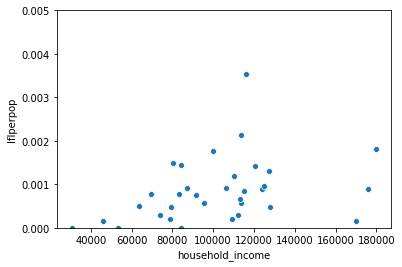

In [122]:
ax = sns.scatterplot(x="household_income", y="lflperpop", data=dflfl)
ax.set(ylim=(0, 0.005))

#### I used this site for the linear regression: https://realpython.com/linear-regression-in-python/#python-packages-for-linear-regression

The following is a regression only for neighborhood in the study!

In [9]:
from sklearn.linear_model import LinearRegression

In [11]:
#Open the file if needed
dflfl = pd.read_csv('census-compiled-data.csv',encoding='utf-8')

In [12]:
x = dflfl[['household_income']]
y = dflfl[['lflperpop']]

In [13]:
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

coefficient of determination: 0.12185556404062636
intercept: [9.16328386e-05]
slope: [[7.57601413e-09]]


## Examine lfls and neighborhoods

In [127]:
dflflhood = dflfl
#or open the census compiled data dflflhood = pd.read_csv('census-compiled-data.csv',encoding='utf-8')

In [128]:
dflflhood = dflflhood.groupby('neighborhood').agg({'household_income': ['mean'], 'pop': ['sum'], 'numlfls':['sum']})
# rename columns
dflflhood.columns = ['avg-median-income', 'pop', 'numlfls']

# reset index to get grouped columns back
dflflhood = dflflhood.reset_index()

In [129]:
dflflhood.head(8)

,neighborhood,avg-median-income,pop,numlfls
0,Central District,98985.250000,16969,12
1,Columbia City,67992.000000,16883,9
2,Laurelhurst,127971.500000,10479,11
3,Montlake,144488.500000,8644,8
4,Northgate,76682.000000,14057,13
5,Phinney-Greenwood,96876.333333,23948,20
6,Queen Anne,113987.571429,35004,20
7,Ravenna,101129.833333,24187,24


#### Diversity

In [2]:
#If necessary. Open census tract csv with the counts of lfls
#I used QGIS to make a csv with the number of lfls per area for each census tract
lflvtract = pd.read_csv('censustracts-neighborhoods.csv',encoding='utf-8')

In [3]:
#open up the diversity data
dfdiv = pd.read_csv('diversity-seattle-census-tract-acs5-2018.csv',encoding='utf-8')

In [4]:
#Merge with the lfl number dataset
dflfldiv = pd.merge(dfdiv, lflvtract, on='tract', how='inner')
dflfldiv = dflfldiv.drop(columns=['simpsons','gini-simp'])
dflfldiv.head()

,tot,wh,afam,amin,as,hw,ot,combo1,combo2,combo3,tract,neighborhood
0,6950,4335,525,30,1286,0,381,393,33,360,12.00,Northgate
1,3988,2893,189,25,406,1,137,337,78,259,17.01,Phinney-Greenwood
2,4493,3553,81,39,405,0,83,332,8,324,17.02,Phinney-Greenwood
3,4789,3504,214,5,805,12,35,214,15,199,19.00,Northgate
4,3647,3120,5,0,298,0,65,159,0,159,20.00,Northgate


In [5]:
dflfldiv = dflfldiv.groupby('neighborhood').agg({'tot': ['sum'], 'wh': ['sum'], 'afam':['sum'], 'amin':['sum'], 'as':['sum'], 'hw':['sum'], 'ot':['sum'], 'combo1':['sum'], 'combo2':['sum'], 'combo3':['sum']})
# rename columns
dflfldiv.columns = ['tot', 'wh', 'afam', 'amin', 'as', 'hw', 'ot', 'combo1', 'combo2', 'combo3']

# reset index to get grouped columns back
dflfldiv = dflfldiv.reset_index()

In [6]:
dflfldiv.head(8)

,neighborhood,tot,wh,afam,amin,as,hw,ot,combo1,combo2,combo3
0,Central District,19498,13757,2675,134,1193,173,513,1053,38,1015
1,Columbia City,18983,6999,5152,159,4960,86,169,1458,0,1458
2,Laurelhurst,11010,8882,303,0,1289,13,45,478,0,478
3,Montlake,9546,8048,109,36,763,38,91,461,60,401
4,Northgate,15386,10959,744,35,2389,12,481,766,48,718


In [7]:
#Calculate Simpsons and gini
def simpsons(row):
    return (row['wh'] / row['tot'])**2 + (row['afam'] / row['tot'])**2 + (row['amin'] / row['tot'])**2 + (row['as'] / row['tot'])**2 + (row['hw'] / row['tot'])**2 + (row['ot'] / row['tot'])**2 + (row['combo1'] / row['tot'])**2 + (row['combo2'] / row['tot'])**2 + (row['combo3'] / row['tot'])**2

dflfldiv['simpsons'] = dflfldiv.apply(simpsons, axis=1)
dflfldiv['gini-simp'] = 1 - dflfldiv['simpsons']
dflfldiv.head(8)

,neighborhood,tot,wh,afam,amin,as,hw,ot,combo1,combo2,combo3,simpsons,gini-simp
0,Central District,19498,13757,2675,134,1193,173,513,1053,38,1015,0.526829,0.473171
1,Columbia City,18983,6999,5152,159,4960,86,169,1458,0,1458,0.289836,0.710164
2,Laurelhurst,11010,8882,303,0,1289,13,45,478,0,478,0.669051,0.330949
3,Montlake,9546,8048,109,36,763,38,91,461,60,401,0.721553,0.278447
4,Northgate,15386,10959,744,35,2389,12,481,766,48,718,0.539426,0.460574


In [8]:
dflfldiv.head(8)

,neighborhood,tot,wh,afam,amin,as,hw,ot,combo1,combo2,combo3,simpsons,gini-simp
0,Central District,19498,13757,2675,134,1193,173,513,1053,38,1015,0.526829,0.473171
1,Columbia City,18983,6999,5152,159,4960,86,169,1458,0,1458,0.289836,0.710164
2,Laurelhurst,11010,8882,303,0,1289,13,45,478,0,478,0.669051,0.330949
3,Montlake,9546,8048,109,36,763,38,91,461,60,401,0.721553,0.278447
4,Northgate,15386,10959,744,35,2389,12,481,766,48,718,0.539426,0.460574
5,Phinney-Greenwood,25401,21431,424,85,1668,14,310,1469,94,1375,0.722881,0.277119
6,Queen Anne,39723,32290,350,182,4072,60,486,2283,187,2096,0.677641,0.322359
7,Ravenna,25957,20587,376,58,3135,98,298,1405,85,1320,0.649513,0.350487


In [ ]:
#Save file as csv
dflfldiv.to_csv('census-lflhood-compiled-data.csv', mode = 'w', index=False)